# Udacicy CarND Term1 Project 5 Vehicle Detection
---
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Import Statements

In [1]:
import glob
import time
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import pickle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque

% matplotlib inline

In [2]:
# Common functions

# Returns RGB image
def readImagesFromPath(path):
    return cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB)

def displayImagesForComparison(leftImg, rightImg, leftTitle, rightTitle, show_axis='off', l_gray=False, r_gray=False):
    fig, (col1, col2) = plt.subplots(1, 2, figsize=(12,8))
    if l_gray == True:
        col1.imshow(leftImg, cmap='gray')
    else:
        col1.imshow(leftImg)
    col1.axis(show_axis)
    col1.set_title(leftTitle, fontsize=20)
    if r_gray == True:
        col2.imshow(rightImg, cmap='gray')
    else:
        col2.imshow(rightImg)
    col2.set_title(rightTitle, fontsize=20)
    col2.axis(show_axis)

## Load Training Data

In [3]:
cars = glob.glob('./training_data/vehicles/**/*.png')
noncars = glob.glob('./training_data/non-vehicles/**/*.png')
print("Car count: {} \nNon-car count: {}".format(len(cars), len(noncars)))


# Load test data
test_cars = glob.glob('test_images/*.jpg')

Car count: 8792 
Non-car count: 8968


#### Visualize the training data

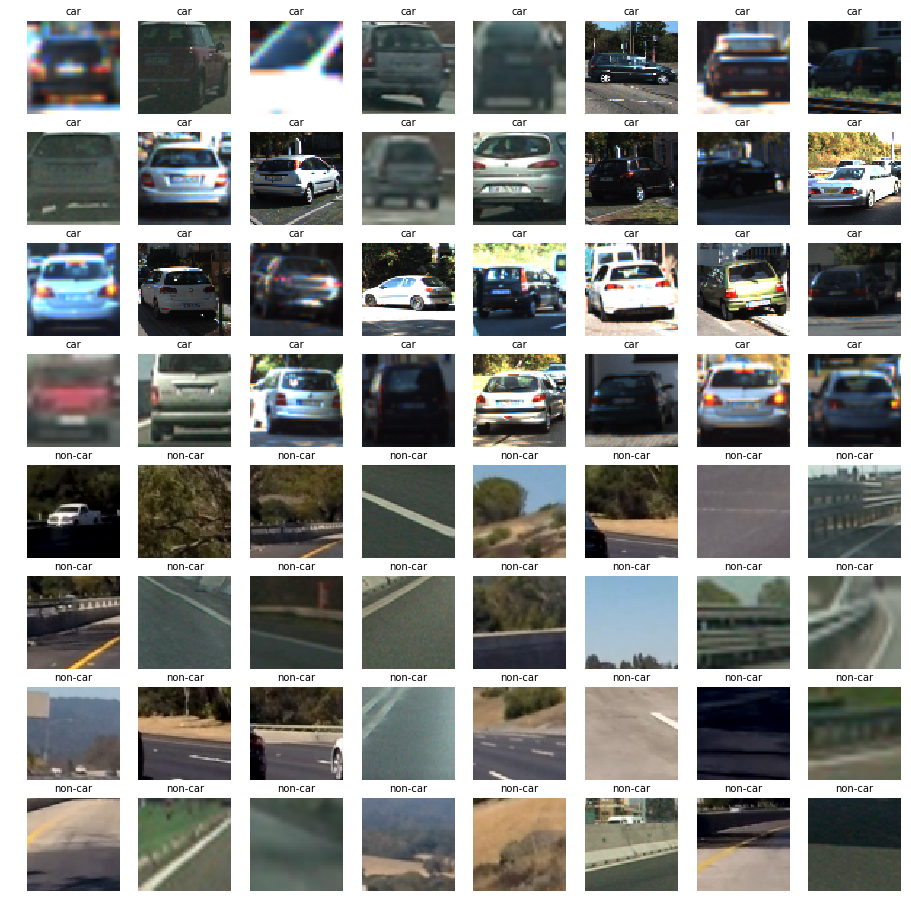

In [4]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(32):
    img = readImagesFromPath(cars[np.random.randint(0,len(cars))])
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = readImagesFromPath(noncars[np.random.randint(0,len(noncars))])
    axs[i].axis('off')
    axs[i].set_title('non-car', fontsize=10)
    axs[i].imshow(img)

## Feature Extraction

In [5]:
# Extract HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Explore the Features
#### Viesualize HOG Features

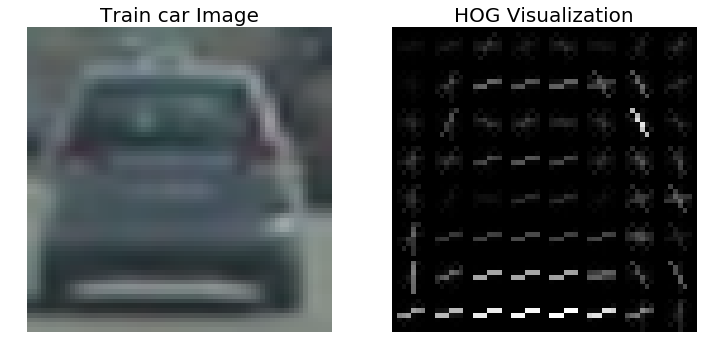

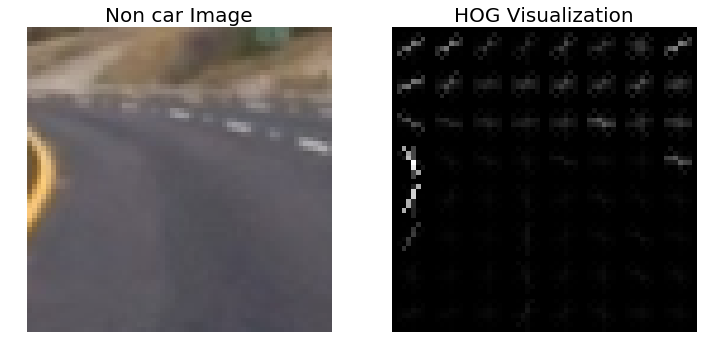

In [6]:
orient = 9
pix_per_cell = 8
cell_per_block = 2

viz_car = readImagesFromPath(cars[4])
viz_noncar = readImagesFromPath(noncars[4])

car_features, car_hog_image = get_hog_features(cv2.cvtColor(viz_car, cv2.COLOR_RGB2GRAY), orient,
                                         pix_per_cell, cell_per_block, vis=True, feature_vec=False)
non_features, noncar_hog_image = get_hog_features(cv2.cvtColor(viz_noncar, cv2.COLOR_RGB2GRAY), orient,
                                         pix_per_cell, cell_per_block, vis=True, feature_vec=False)

displayImagesForComparison(viz_car, car_hog_image, 'Train car Image', 'HOG Visualization', r_gray=True)
displayImagesForComparison(viz_noncar, noncar_hog_image, 'Non car Image', 'HOG Visualization', r_gray=True)


#### Visualize the images in different color space before feature extraction

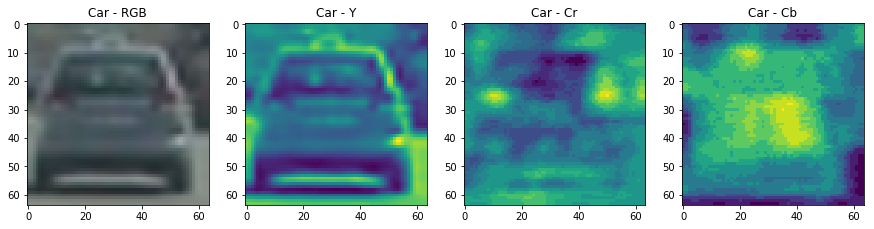

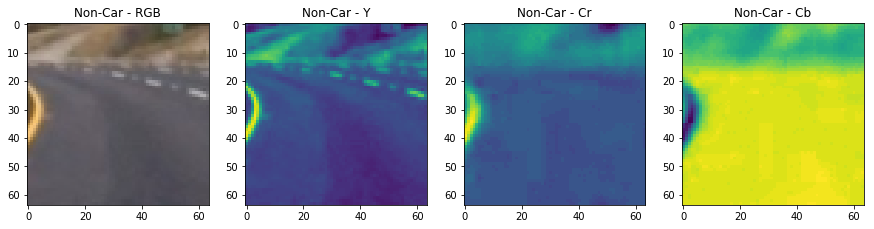

In [7]:
viz_car_YCrCb = cv2.cvtColor(viz_car, cv2.COLOR_RGB2YCrCb)
viz_noncar_YCrCb = cv2.cvtColor(viz_noncar, cv2.COLOR_RGB2YCrCb)

def displayColorSpaceComparison(rgb, ycrb, title): 
    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(rgb)
    axes[0].set_title('{} - RGB'.format(title))
    axes[1].imshow(ycrb[:,:,0])
    axes[1].set_title('{} - Y'.format(title))
    axes[2].imshow(ycrb[:,:,1])
    axes[2].set_title('{} - Cr'.format(title))
    axes[3].imshow(ycrb[:,:,2])
    axes[3].set_title('{} - Cb'.format(title))

displayColorSpaceComparison(viz_car, viz_car_YCrCb, 'Car')
displayColorSpaceComparison(viz_noncar, viz_noncar_YCrCb, 'Non-Car')

### Visualize HOG on YCrCb color space images

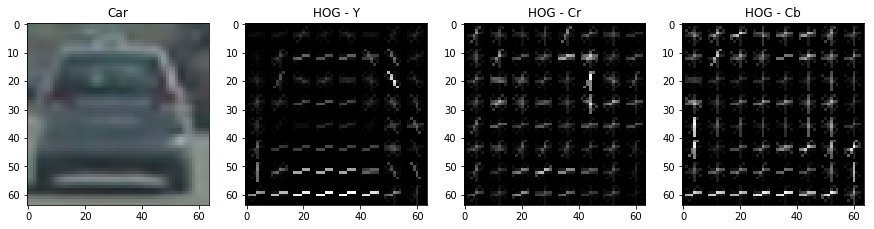

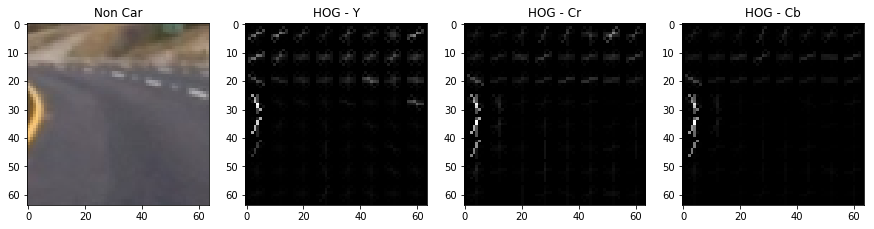

In [8]:
def displayHOGColorSpaceComparison(rgb, ycrb, title):
    feature, hog_y = get_hog_features(ycrb[:,:,0], orient, pix_per_cell, cell_per_block,
                                vis=True, feature_vec=True)
    feature, hog_Cr = get_hog_features(ycrb[:,:,1], orient, pix_per_cell, cell_per_block,
                            vis=True, feature_vec=True)
    feature, hog_Cb = get_hog_features(ycrb[:,:,2], orient, pix_per_cell, cell_per_block,
                            vis=True, feature_vec=True)
    fig, axes = plt.subplots(ncols=4, figsize=(15,15))
    axes[0].imshow(rgb)
    axes[0].set_title('{}'.format(title))
    axes[1].imshow(hog_y, cmap='gray')
    axes[1].set_title('HOG - Y'.format(title))
    axes[2].imshow(hog_Cr, cmap='gray')
    axes[2].set_title('HOG - Cr'.format(title))
    axes[3].imshow(hog_Cb, cmap='gray')
    axes[3].set_title('HOG - Cb'.format(title))

displayHOGColorSpaceComparison(viz_car, viz_car_YCrCb, 'Car')
displayHOGColorSpaceComparison(viz_noncar, viz_noncar_YCrCb, 'Non Car')

### Extract the features

In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### Train SVM Calssifier

#### Setting the Hyper-parameters

In [10]:
color_space = 'YCrCb'
spatial_size = (32, 32)
hist_bins = 32
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_feat = True
hist_feat = True
hog_feat = True

#### Extract Features from Images

In [11]:
t = time.time()

print("Extracting car features")
car_features = extract_features(cars, color_space=color_space,
                                hog_channel=hog_channel)
print("Extracting non-car features")
noncar_features = extract_features(noncars, color_space=color_space,
                                hog_channel=hog_channel)

t2 = time.time()
print(round(t2 - t, 2), 'seconds to extract the features.')  

X = np.vstack((car_features, noncar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))

Extracting car features
Extracting non-car features
75.51 seconds to extract the features.
Feature vector length: 8460


### Train Classifier (I am using linear SVC)

In [12]:
# Use a linear SVC
svc = LinearSVC()
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'seconds to train SVC.')

# Get the pridiction results
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])

# Get the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

8.42 seconds to train SVC.


### Save Results

In [40]:
# save the result
filename = "saved_data/svm.pkl"
joblib.dump(svc, filename)
pickle.dump(scaled_X,open("saved_data/scaled_X_data.pkl","wb"))
pickle.dump(y,open("saved_data/y_data.pkl","wb"))
pickle.dump(X_scaler, open("saved_data/X_scaler.pkl","wb"))

print("Trained model saved.")

# Save training parameters
data={
    'svc': svc,
    'X_scaler': X_scaler,
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'spatial_size' : spatial_size,
    'hist_bins': hist_bins,
    'hog_channel': hog_channel
     }

with open('saved_data/model-params.pk', 'wb') as pFile:
    pickle.dump(data, pFile)

print('Training parameters saved.')

Trained model saved.
training parameters saved.


### Sliding window technique to identify vehicle

In [17]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # Default start and end is per image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [18]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [19]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

### Draw the boxes

In [20]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

### Draw rectangle using slider window method

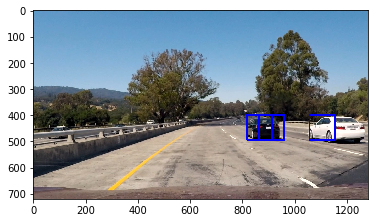

In [28]:
image = readImagesFromPath(test_cars[0])
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[350, None], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

result = plt.imshow(window_img)

Window Count: 8


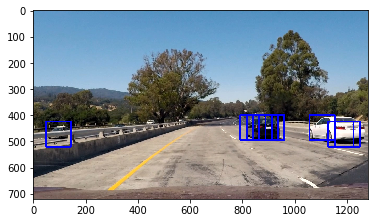

In [31]:
#  A function that can extract features using HOG sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    ctrans_tosearch = cv2.cvtColor(img[ystart:ystop,:,:], cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    on_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                on_windows.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                    
    return draw_img, on_windows

test_img = readImagesFromPath(test_cars[0])
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img, all_windows = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                                 orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

print('Window Count: {}'.format(len(all_windows)))
result = plt.imshow(out_img)

### Heat Map Operation

In [23]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        #cv2.rectangle(img, bbox[0], bbox[1], color=(0,0,255), 6)
        img = draw_boxes(img, [bbox], color=(0, 0, 255), thick=6)
    # Return the image
    return img

### Heat Map Visualization

#### heat map variation with threshold values

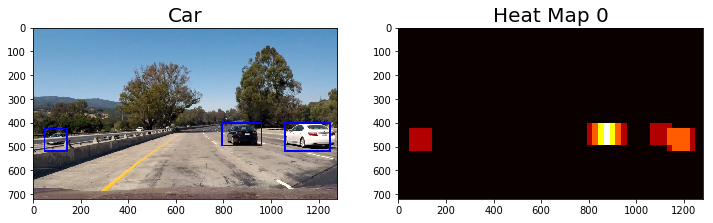

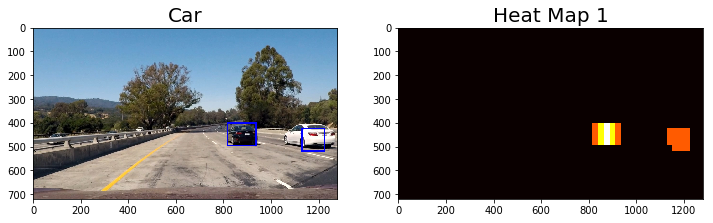

In [35]:
def get_heat_map_and_cars(img, threshold):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    box_list = all_windows

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heat

def displayHeatMap(leftImg, rightImg, leftTitle, rightTitle):
    fig, (col1, col2) = plt.subplots(1, 2, figsize=(12,8))
    col1.imshow(leftImg, cmap='hot')
    col1.set_title(leftTitle, fontsize=20)
    col2.imshow(rightImg, cmap='hot')
    col2.set_title(rightTitle, fontsize=20)

car_post0, heat0 = get_heat_map_and_cars(readImagesFromPath(test_cars[0]), 0)
car_post1, heat1 = get_heat_map_and_cars(readImagesFromPath(test_cars[0]), 1)

displayHeatMap(car_post0, heat0, 'Car', 'Heat Map 0')
# check the difference in box size with changing threashold
displayHeatMap(car_post1, heat1, 'Car', 'Heat Map 1')

#### Heat map visualization for all images

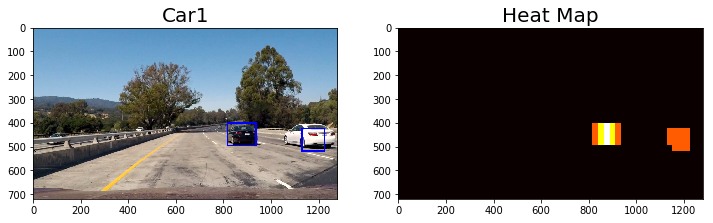

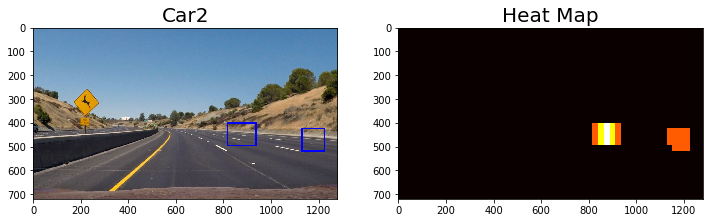

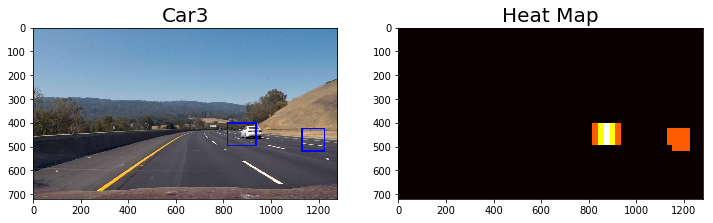

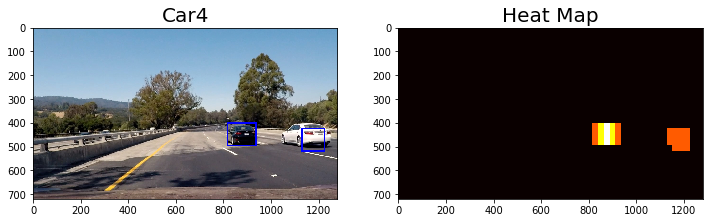

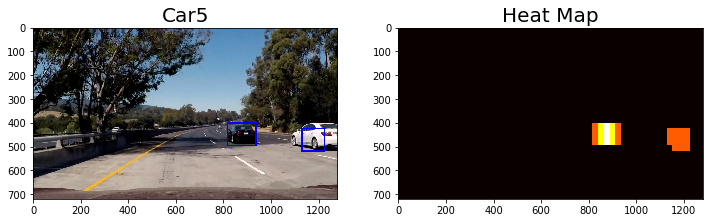

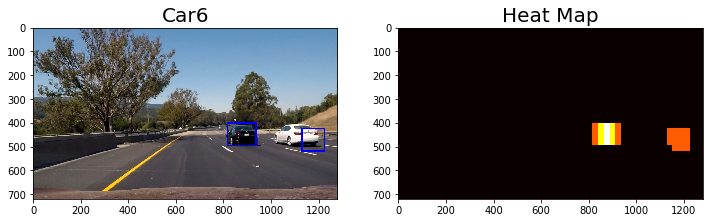

In [75]:
for i in np.arange(6):
    car_post, heat = get_heat_map_and_cars(readImagesFromPath(test_cars[i]), 1)
    displayHeatMap(car_post, heat, 'Car{}'.format(i+1), 'Heat Map')


### Build video pipeline

In [46]:
class Vehicle:
    def __init__(self, color_space='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2,
                     hog_channel="ALL", spatial_size=(32, 32), hist_bins=32, spatial_feat=True,hist_feat=True,
                     hog_feat=True, ystart_ystop_scale=[(380, 480, 1), (400, 600, 1.5), (500, 700, 2.5)],
                     threshold=2):
                
        self.color_space = color_space
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.ystart_ystop_scale = ystart_ystop_scale
        self.threshold = threshold
        
        # Current HeatMap
        self.heatmap = None

        # Heat Image for the Last Three Frames
        self.heat_images = deque(maxlen=3)

        # Current Frame Count
        self.frame_count = 0
        self.full_frame_processing_interval = 10

        # Xstart
        self.xstart = 600

        # Kernal For Dilation
        self.kernel = np.ones((50, 50))
        
        self.X_scaler = pickle.load(open("./saved_data/X_scaler.pkl", "rb"))
        self.svc = joblib.load("./saved_data/svm.pkl")

    def identify(self, img):
        X_scaler = self.X_scaler
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        svc = self.svc

        box_list = []

        draw_img = np.copy(img)
        img = img.astype(np.float32) / 255

        if self.frame_count % self.full_frame_processing_interval == 0:
            mask = np.ones_like(img[:, :, 0])
        else:
            mask = np.sum(np.array(self.heat_images), axis=0)
            mask[(mask > 0)] = 1
            mask = cv2.dilate(mask, self.kernel, iterations=1)

        self.frame_count += 1

        for (ystart, ystop, scale) in self.ystart_ystop_scale:

            nonzero = mask.nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])

            if len(nonzeroy) != 0:
                ystart = max(np.min(nonzeroy), ystart)
                ystop = min(np.max(nonzeroy), ystop)
            if len(nonzeroy) != 0:
                xstart = max(np.min(nonzerox), self.xstart)
                xstop = np.max(nonzerox)
            else:
                continue

            if xstop <= xstart or ystop <= ystart:
                continue

            img_tosearch = img[ystart:ystop, xstart:xstop, :]
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
            if scale != 1:
                imshape = ctrans_tosearch.shape
                ys = np.int(imshape[1] / scale)
                xs = np.int(imshape[0] / scale)
                if (ys < 1 or xs < 1):
                    continue
                ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

            if ctrans_tosearch.shape[0] < 64 or ctrans_tosearch.shape[1] < 64:
                continue

            ch1 = ctrans_tosearch[:, :, 0]
            ch2 = ctrans_tosearch[:, :, 1]
            ch3 = ctrans_tosearch[:, :, 2]

            # Define blocks and steps as above
            nxblocks = (ch1.shape[1] // pix_per_cell) - 1
            nyblocks = (ch1.shape[0] // pix_per_cell) - 1
            nfeat_per_block = orient * cell_per_block ** 2
            # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
            window = 64
            nblocks_per_window = (window // pix_per_cell) - 1
            cells_per_step = 2  # Instead of overlap, define how many cells to step
            nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
            nysteps = (nyblocks - nblocks_per_window) // cells_per_step

            # Compute individual channel HOG features for the entire image
            hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
            hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

            for xb in range(nxsteps + 1):
                for yb in range(nysteps + 1):
                    ypos = yb * cells_per_step
                    xpos = xb * cells_per_step

                    # Extract HOG for this patch
                    hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
                    hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                    xleft = xpos * pix_per_cell
                    ytop = ypos * pix_per_cell

                    # Extract the image patch
                    subimg = ctrans_tosearch[ytop:ytop + window, xleft:xleft + window]

                    # Get color features
                    spatial_features = bin_spatial(subimg, size=spatial_size)
                    hist_features = color_hist(subimg, nbins=hist_bins)

                    # Scale features and make a prediction
                    test_features = X_scaler.transform(
                        np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
                    # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
                    test_prediction = svc.predict(test_features)
                    if test_prediction == 1:
                        xbox_left = xstart + np.int(xleft * scale)
                        ytop_draw = np.int(ytop * scale)
                        win_draw = np.int(window * scale)
                        box_list.append(
                            ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))

        # Add heat to each box in box list
        self.add_heatmap_and_threshold(draw_img, box_list, self.threshold)

        # Find final boxes from heatmap using label function
        labels = label(self.heatmap)
        Vehicle.draw__box(draw_img, labels)
        return draw_img
    
    def add_heatmap_and_threshold(self, draw_img, bbox_list, threshold):
        heatmap = np.zeros_like(draw_img[:, :, 0]).astype(np.float)

        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        self.heat_images.append(heatmap)
        self.heatmap = np.sum(np.array(self.heat_images), axis=0)
        self.heatmap[self.heatmap <= threshold] = 0

    @staticmethod
    def draw__box(img, labels):
        for car in range(1, labels[1] + 1):
            nonzero = (labels[0] == car).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)

### Test pipeline with test images

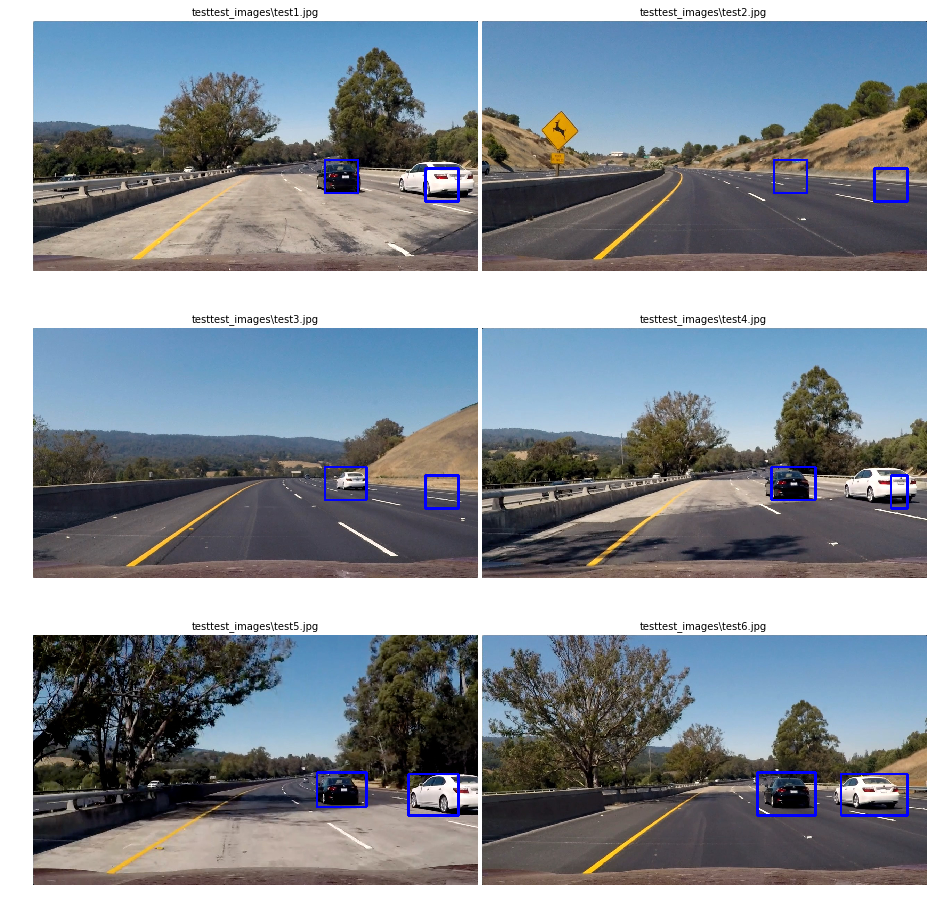

In [62]:
# we can tweak different values here to see the different results
vehicle = Vehicle(threshold=2)

fig, axs = plt.subplots(3,2, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.01)
axs = axs.ravel()

for i in np.arange(6):
    img = readImagesFromPath(test_cars[i])
    output = vehicle.identify(img)
    axs[i].axis('off')
    axs[i].set_title('test{}'.format(test_cars[i]), fontsize=10)
    axs[i].imshow(output)

### Run pipeline on Video

In [63]:
def process_video(video_in, video_out):
    video = VideoFileClip(video_in)
    clip = video.fl_image(vehicle.identify)
    %time clip.write_videofile(video_out, audio=False)
    
#process_video('./test_video.mp4', './output_videos/test_video_output.mp4')
process_video('./project_video.mp4', './output_videos/project_video_output.mp4')

[MoviePy] >>>> Building video ./output_videos/project_video_output.mp4
[MoviePy] Writing video ./output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [05:40<00:00,  3.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_output.mp4 

Wall time: 5min 41s
